In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy
import pandas as pds
from scipy.optimize import minimize

In [2]:
ge_data = pds.read_csv("SuperCDMS/PhysRevD.99.062001-data/MarchAprilFinal.txt", skiprows=1, \
                         names=['time', 'blah'], \
                         delim_whitespace=False
                     )

ge_data = ge_data.sort_values(by='time')

t = np.asarray(ge_data["time"], dtype=np.float32)


In [3]:
min_t=np.min(t)

#construct histogram from our data, every bin is roughly 12 hours
counts, bins = np.histogram(t-min_t,bins=72)
thing = (bins[:-1]+bins[1:])/2
error1 = [0.00,0.37,0.74,1.10,2.34,2.75,3.82,4.25,5.30,6.33,6.78,7.81,8.83,9.28]
error2 = [1.29,2.75,4.25,5.30,6.78,7.81,9.28,10.30,11.32,12.79,13.81,14.82,16.29,17.30]
ntot_plus = np.zeros(np.shape(counts))
ntot_minus = np.zeros(np.shape(counts))
for i,ncount in enumerate(counts):
    if ncount<=20:
        ntot_plus[i] = error2[ncount]-ncount
        ntot_minus[i] = ncount-error1[ncount]
    else:
        ntot_plus[i] = np.sqrt(ncount)
        ntot_minus[i] = np.sqrt(ncount)

totcnt = 0
for i in range(len(counts)):
    totcnt+=counts[i]
print(totcnt)

189


In [4]:
def log_likelihood_func(theta, t_stop, times, nvec): 
    alpha,b,scale=theta
    
    #initialize array of center time for each bin
   # times = [] 
   # for i in range(len(nvec)):
   #     result=(tstop/(len(nvec))*nvec[i])
   #     times.extend([result])
    
    #initialize array of lambdas for each bin according to our model
    lam_array = [] 
    for i in range(len(nvec)):
        result = scale*((1/(1+b))*np.exp(-times[i]/alpha)/(alpha*(1-np.exp(-t_stop/alpha)))+(b)/t_stop)
        lam_array.extend([result])
    
    #Sterling's approximation array
    sterling_array = []
    for i in range(len(nvec)):
        if nvec[i]>12:
                sterling_array.append(nvec[i]*np.log(nvec[i])-nvec[i])
        else:
                sterling_array.append(np.log(np.math.factorial(nvec[i])))
    
    model = 0
    for i in range(len(nvec)):
        model +=(-lam_array[i] + nvec[i]*np.log(lam_array[i])-sterling_array[i])
    #model=totcnt*model
    return model


In [5]:
alpha = 250
b=1
tstop = 1440
scale=2000

nll = lambda *args: -log_likelihood_func(*args)
initial = np.array([alpha,b,scale])  
soln = scipy.optimize.minimize(nll, initial, args=(tstop, thing, counts), bounds=[(0,np.inf),(0,50),(0,np.inf)]) #add bounds?
alphaml, bml, scaleml = soln.x
print(soln.x)

'''
nll = lambda args: -log_likelihood_func(args, tstop, counts)
initial = np.array([alpha, b])
soln = scipy.optimize.minimize(nll, initial, bounds=[(0, 9999), (0, 9999)])
alphaml, bml = soln.x'''

[2.53897696e+02 4.84029488e-01 2.50568802e+03]


'\nnll = lambda args: -log_likelihood_func(args, tstop, counts)\ninitial = np.array([alpha, b])\nsoln = scipy.optimize.minimize(nll, initial, bounds=[(0, 9999), (0, 9999)])\nalphaml, bml = soln.x'

In [6]:
def prior(theta): #this sets the prior conditions of our parameters
    alpha, b, scale= theta
    if alpha>=0 and b>=0 and scale>0:
        return 0.0
    return -np.inf

def prob(theta, t_stop, times, nvec):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf 
    result = lp + log_likelihood_func(theta, t_stop, times, nvec)
    if np.isnan(np.asarray([result])):
        return -np.inf
    return result

In [7]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, prob, args=(tstop, thing, counts)
)

sampler.run_mcmc(pos, 7000, progress=True);

100%|██████████| 7000/7000 [02:48<00:00, 41.55it/s]


[45.35987577 44.91180266 41.34043538]
(14720, 3)
253.89769598435802 0.4840294883831166 2505.6880165651646


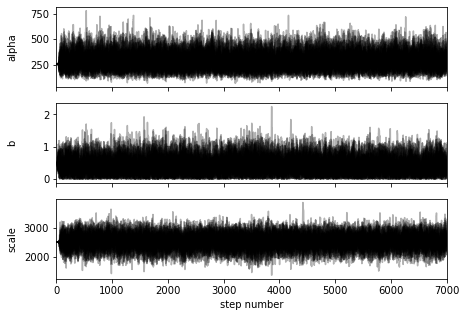

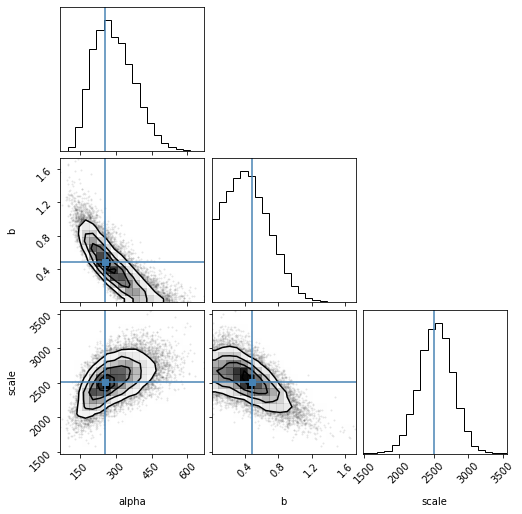

In [8]:
fig, axes = plt.subplots(3, figsize=(7, 5), sharex=True)
samples = sampler.get_chain()
labels = ["alpha","b","scale"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
print(alphaml,bml,scaleml)

fig = corner.corner(
    flat_samples, labels=labels, truths=[alphaml, bml,scaleml]
);

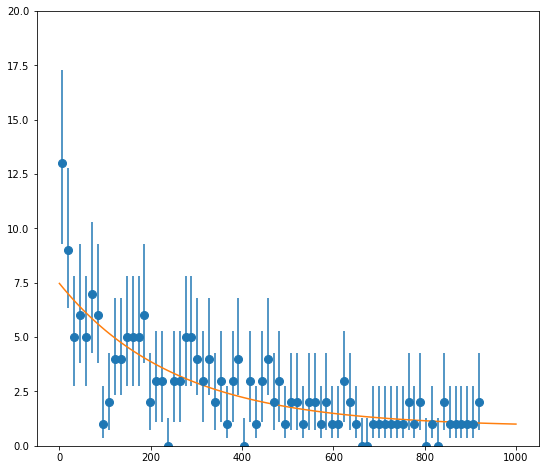

In [9]:
tstop=1440
#alphaml=300
#bml=10
scale1 = 365
scale2 = 3650

def function(t, tstop, alpha, B, scale):
    return(scale*((1/(1+B))*np.exp(-t/alpha)/(alpha*(1-np.exp(-tstop/alpha)))+(B)/tstop))
           
#print(function(1,2,3,4))
fig,axes = plt.subplots(1,1, figsize=(9,8))

ax1=axes
ax1.errorbar(thing, counts, yerr=[ntot_minus,ntot_plus], marker='o', markersize=8, linestyle = 'none')

#print(function(0,1450,271.2,1)*4000)
x = np.linspace(0,1000,num=100) 
#print (function(x,tstop,15,20))

ax1.plot(x,function(x,tstop,254,0.5,2505))
#ax1.plot(x,function(x,tstop,264,1,scale2))

#ax1.plot(x,function(x,tstop,alphaml,bml, scale2))
plt.ylim([0,20])
plt.show(fig)

In [10]:
tstop=1440
bml = 1
alphaml = 264
scale1=365
scale2=3650


times = [] 
for i in range(len(counts)):
    result=(tstop/(len(counts))*counts[i])
    times.extend([result])
        
lam_array1 = [] 
for i in range(len(counts)):
    result = scale1*((1/(1+bml))*np.exp(-times[i]/alphaml)/(alphaml*(1-np.exp(-tstop/alphaml)))+(bml)/tstop)
    lam_array1.extend([result])
        
lam_array2 = [] 
for i in range(len(counts)):
    result = scale2*((1/(1+bml))*np.exp(-times[i]/alphaml)/(alphaml*(1-np.exp(-tstop/alphaml)))+(bml)/tstop)
    lam_array2.extend([result])
        

sterling_array = []
for i in range(len(counts)):
    if counts[i]>12:
            sterling_array.append(counts[i]*np.log(counts[i])-counts[i])
    else:
            sterling_array.append(np.log(np.math.factorial(counts[i])))
                
likelihood1= 0
for i in range(len(counts)):
    likelihood1 +=(-lam_array1[i] + counts[i]*np.log(lam_array1[i])-sterling_array[i])
        
likelihood2= 0
for i in range(len(counts)):
    likelihood2 +=(-lam_array2[i] + counts[i]*np.log(lam_array2[i])-sterling_array[i])

print("Log Likelihood 1:", likelihood1)
print("Log Likelihood 2:", likelihood2)

Log Likelihood 1: -257.3224938379754
Log Likelihood 2: -359.94829415147115


In [11]:
likely1= log_likelihood_func([264,1,365], tstop, thing, counts)
likely2= log_likelihood_func([264,1,3650], tstop, thing, counts)
print(likely1, likely2)

-297.6217767161998 -151.15230313516673


In [12]:
alphaerr= np.sqrt(np.var(flat_samples[:,0]))
berr=np.sqrt(np.var(flat_samples[:,1]))
scaleerr=np.sqrt(np.var(flat_samples[:,2]))
print(alphaerr,berr,scaleerr)

84.48154439677143 0.25946020666084907 243.14897811384589
